Processing Workflow for LPR data


1.   Bandpass filter
2.   Zero correction
3.   Horizzontal High pass filter
4.   Exponential gain



In [47]:
#imports matplotlib, numpy, scipy and tqdm
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.signal import butter,filtfilt
from tqdm import tqdm

In [60]:
#define data path 
data_path = 'LPR_data/'
#load data and normalize to 1
data = np.load(data_path + 'stacked_int16.npy')
data = data/np.max(np.abs(data))

In [49]:
#define dt and dx
dx = 0.06
dt = 0.312500*1e-9

In [50]:
#define lowpass and highpass filter. return filtered data
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / (0.5 * fs)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_high_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / (0.5 * fs)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

In [51]:
#zero correction function
def zero_corrections(data):
  data_2 = np.zeros((data.shape))
  for i in tqdm(range(data.shape[0])):
    idx = np.where((np.abs(data[i, :])>0.5))[0][0]
    data_2[i, :-idx] = data[i, idx:]
  return data_2

In [52]:
#horizzontal high pass filter
def horizzontal_high_filter(data, time_delay, cutoff, fs, order):
    normal_cutoff = cutoff / (0.5 * fs)
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = data
    for i in tqdm(range(time_delay, data.shape[1])):
      y[:, i] = filtfilt(b, a, data[:, i])
    return y

In [53]:
#Fourier transform 
def fft_data(pred, dt):
  from scipy.fft import rfft, rfftfreq
  l = np.abs(rfft(pred[0, :])).shape[0]
  a = np.zeros(l)
  for i in range(pred.shape[0]):
    a += np.abs(rfft(pred[i, :]))
    xf = rfftfreq((pred.shape[1]), dt)
  return xf, a/pred.shape[0]


In [54]:
#function for plot the data
def plot_data(datas, lims=0.01):
  plt.figure(figsize=[20, 10])
  plt.title('filtered matrix')
  plt.imshow(datas.T, cmap = 'seismic', aspect = 'auto', vmin = -lims, vmax = lims, extent=[0, datas.shape[0]*dx, datas.shape[1]*dt, 0])
  plt.xlabel(['Distance [m]'])
  plt.ylabel(['TWT [s]'])

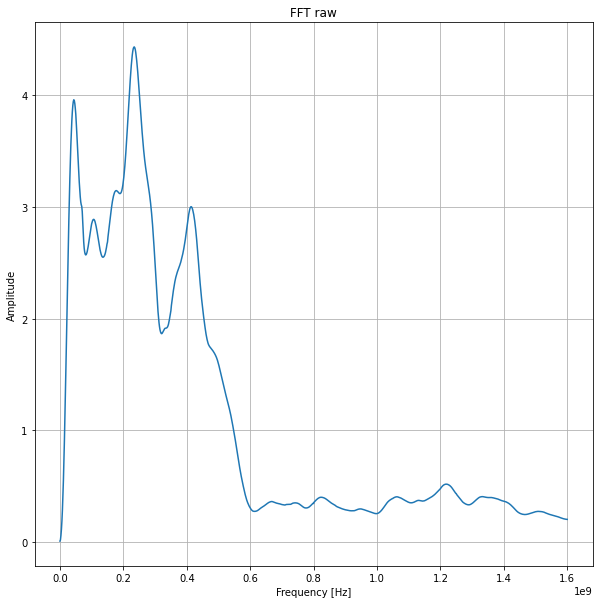

In [61]:
#FT and plot
plt.figure(figsize=[10, 10])
x, y = fft_data(data, dt)
plt.title('FFT raw')
plt.plot(x, y)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.grid(True)

In [62]:
#apply highpass and lowpass to the data
data = butter_high_filter(data, 100*1e6, 1/dt, 5)
data = butter_lowpass_filter(data, 600*1e6, 1/dt, 5)

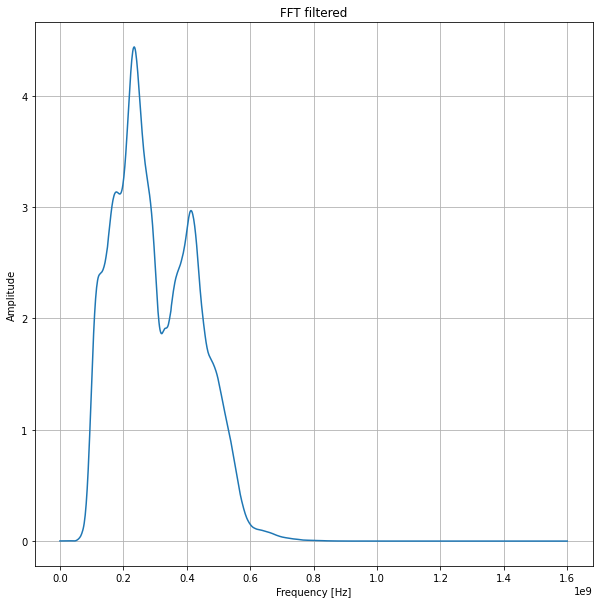

In [64]:
#FT and plot
plt.figure(figsize=[10, 10])
plt.title('FFT filtered')
x, y = fft_data(data, dt)
plt.plot(x, y)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.grid(True)

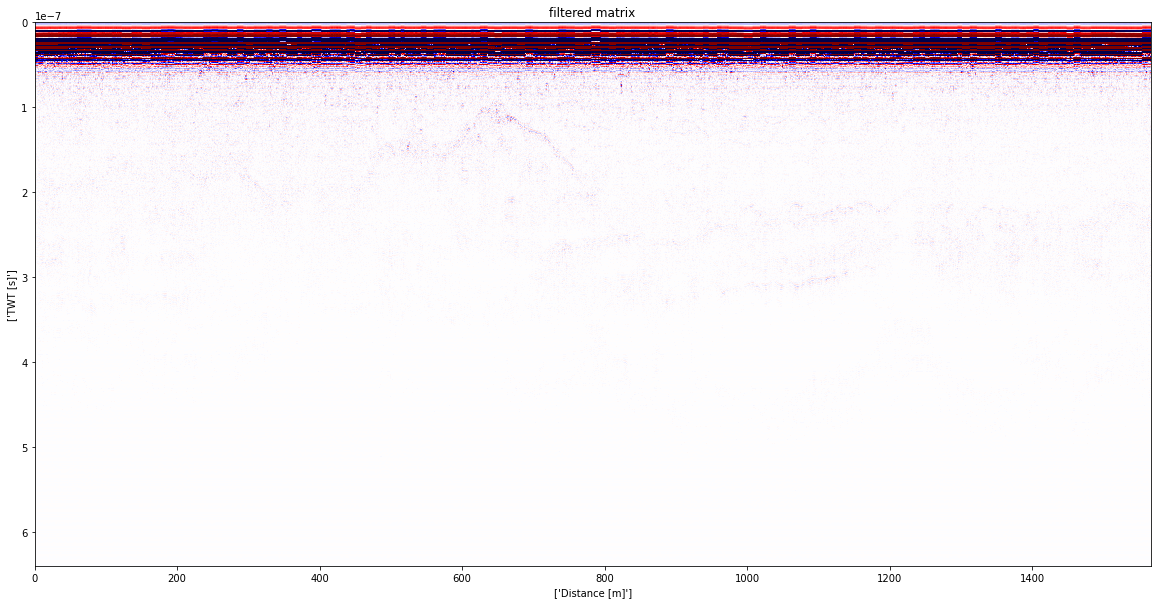

In [63]:
plot_data(data)

In [65]:
#apply zero correction
data = zero_corrections(data)

100%|██████████| 26102/26102 [00:00<00:00, 121271.16it/s]


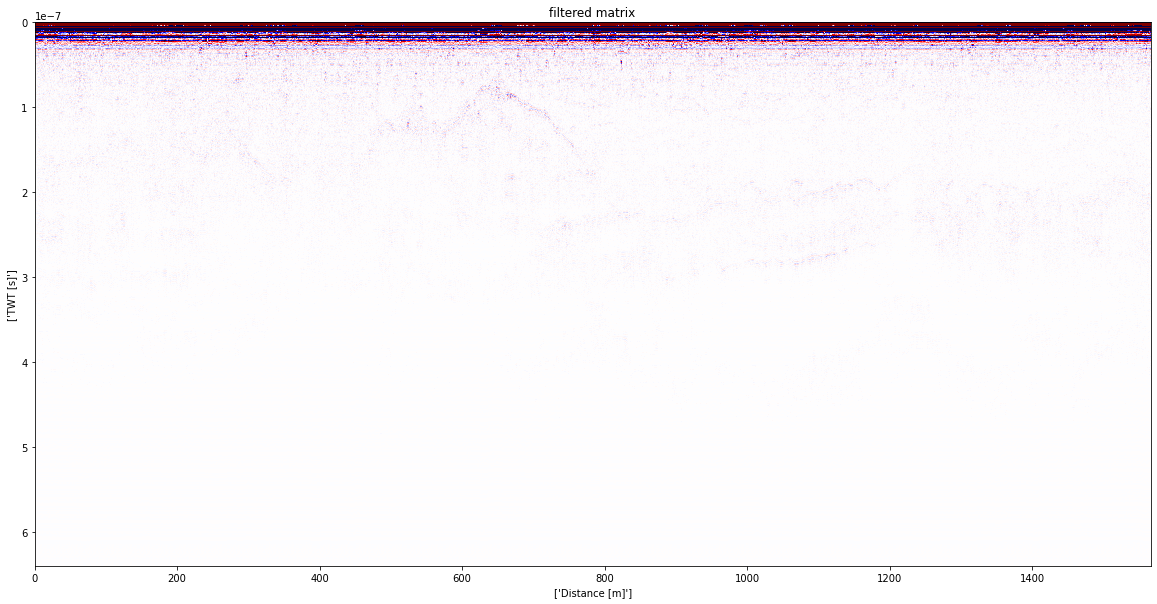

In [66]:
plot_data(data)

In [67]:
#apply horizzontal high pass filter
data = horizzontal_high_filter(data, 30, 9.6*1e6, 1/dt, 5)

100%|██████████| 2018/2018 [00:02<00:00, 698.91it/s]


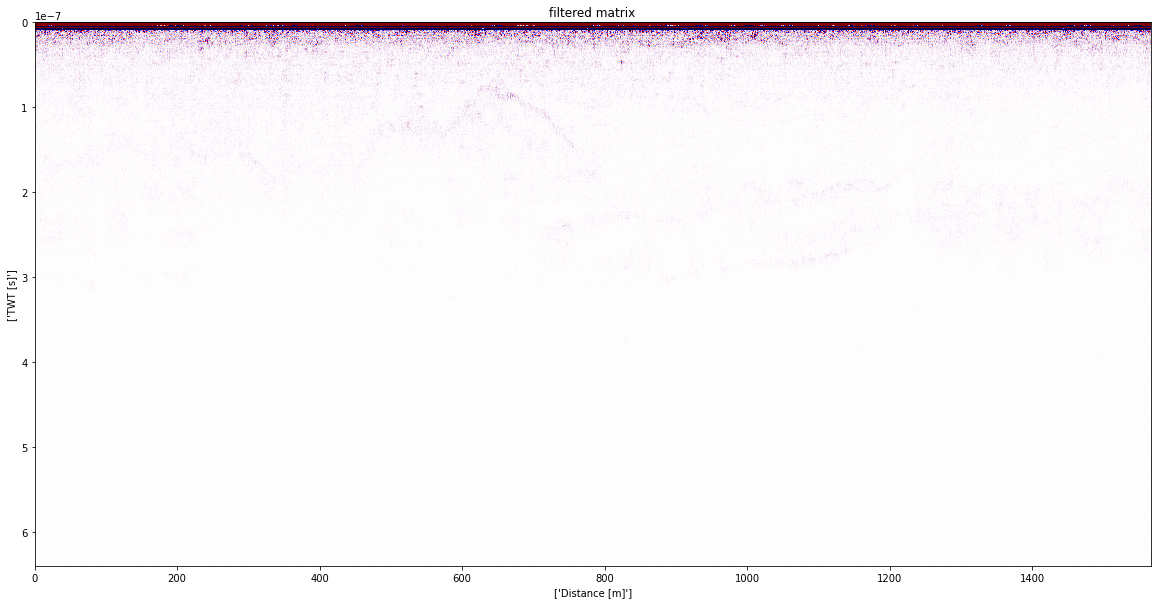

In [68]:
plot_data(data)

In [69]:
#apply exponential gain with 1.7 as exponent (try and error for the right exponent)
t = np.expand_dims(np.linspace(0, data.shape[1] *dt, data.shape[1]), axis=0)
data = data*t**1.7
data = data/np.max(np.abs(data))

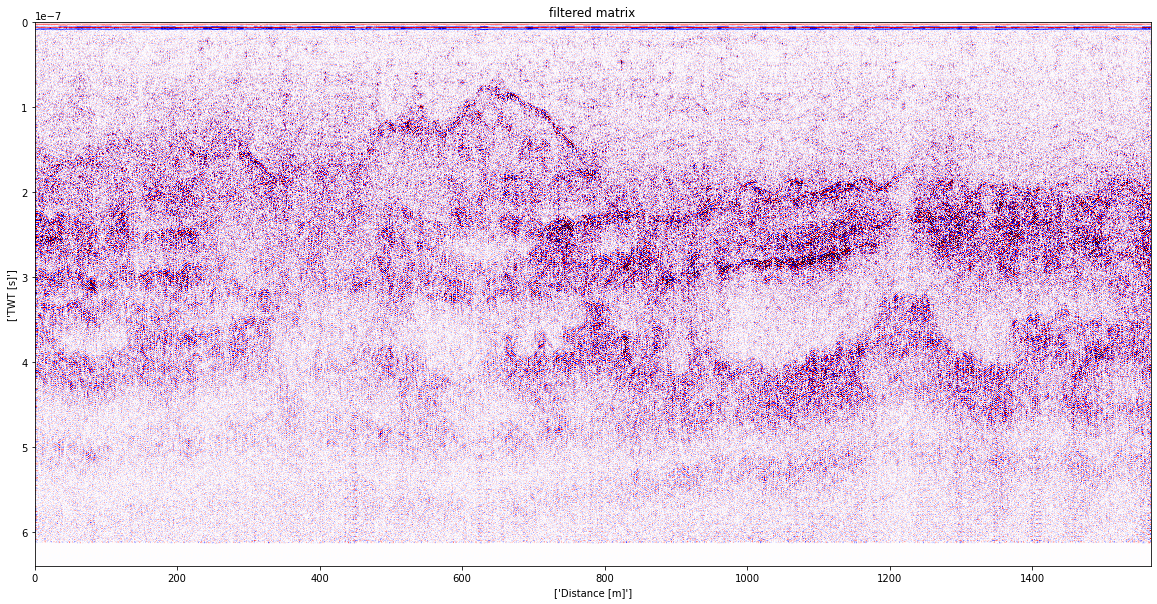

In [70]:
plot_data(data, lims=0.1)